In [1]:
#import dependencies library
# the enviornment library
import gym

#the AI framework 
import tensorflow as tf
import tensorflow.keras as keras 
import numpy as np

#just for ploting stuf
import cv2
import matplotlib.pyplot as plt
import tqdm

from collections import deque


/Users/jonathanlamontange-kratz/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [ ]:
!pip install atari-py
import urllib.request
urllib.request.urlretrieve('http://www.atarimania.com/roms/Roms.rar','Roms.rar')
!pip install unrar
!unrar x Roms.rar
!mkdir rars
!mv HC\ ROMS   rars
!mv ROMS  rars
!python -m atari_py.import_roms rars

In [2]:
environment=gym.make("Breakout-v0")

/Users/jonathanlamontange-kratz/Library/Python/3.9/lib/python/site-packages/gym/envs/registration.py:505: UserWarning: WARN: The environment Breakout-v0 is out of date. You should consider upgrading to version `v5` with the environment ID `ALE/Breakout-v5`.
  logger.warn(
A.L.E: Arcade Learning Environment (version 0.7.5+db37282)
[Powered by Stella]


In [3]:
print(environment.unwrapped.get_action_meanings())

['NOOP', 'FIRE', 'RIGHT', 'LEFT']


In [4]:
action_space=environment.action_space.n
print("The number of action is :({}) and which is the number of output of Neural Network".format(action_space))

The number of action is :(4) and which is the number of output of Neural Network


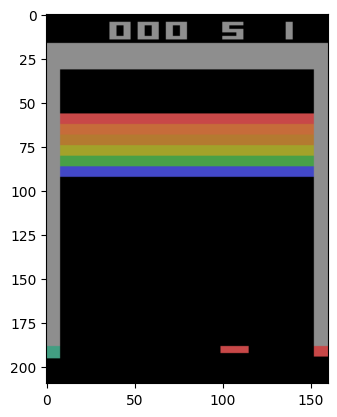

In [5]:
state=environment.reset()
plt.imshow(state)


In [6]:
class FireResetEnv(gym.Wrapper):
    """
    This class is Warpper where we make sure that the game is runing, becouse in some environment in gym library should 
    start the game by action " 1 " in most of the game so by doing this we make sure that the game is roling.
    """
    def __init__(self, env=None):
        super(FireResetEnv, self).__init__(env)
        assert env.unwrapped.get_action_meanings()[1] == 'FIRE'
        assert len(env.unwrapped.get_action_meanings()) >= 3
        
    def step(self, action):
        return self.env.step(action)
    
    def reset(self):
        self.env.reset()
        obs, _, done, _ = self.env.step(1)
        if done:
            self.env.reset()
            obs, _, done, _ = self.env.step(2)
            if done:
                self.env.reset()
        return obs


In [7]:
env=FireResetEnv(environment)


In [8]:
#The size of trainig example 
BATCH_SIZE=1

# size of frame the input tensor to the model.
WIDTH=84
HIGHT=84
CHANNELs=4

# the Number of support in discrete distribution parameter 
ATOMS=51
# the range that the support value derived from.
VMIN=-10
VMAX=10

#numbe of action
ACTIONS=4 #env.action_space.n

# the step size between supports 
DELTA_Z=(VMAX-VMIN)/(ATOMS-1)

# the distribuation parameter.
Z=np.linspace(VMIN,VMAX,ATOMS,dtype=np.float32)


In [9]:
keras.backend.clear_session()

class CategoricalDQN(keras.Model):
    def __init__(self,output_dims,**kwargs):
        super().__init__(**kwargs)
        
        #The conv layers in the model 
        self.conv=keras.Sequential([
            keras.layers.Conv2D(32,8,strides=4,padding='valid',activation='relu'),
            keras.layers.Conv2D(64,4,strides=2,padding='valid',activation='relu'),
            keras.layers.Conv2D(64,3,strides=1,padding='valid',activation='relu'),
            keras.layers.Flatten()
        ])
        
        self.fc=keras.layers.Dense(512,activation='relu')
        self.fc_output=keras.layers.Dense(output_dims)
        
        
    def call(self,x):
        #find the batch this important if we try to pass one example or more so the batch is not fixed.
        batch_size=x.shape[0]
        conv_out = self.conv(x)
        fc_1 = self.fc(conv_out)
        # the output is [batch_size,Action*AToms] if actions is 4 the the shape is [batch_size,204]
        out = self.fc_output(fc_1)
        
        # the reshape step were we reshape the output 
        out = tf.reshape(out,[batch_size,-1,ATOMS])
        # apply the softmax function to the distribuation 
        return keras.activations.softmax(out,axis=2)


In [10]:
model=CategoricalDQN(ACTIONS*ATOMS)
model_2=CategoricalDQN(ACTIONS*ATOMS)
#this step is just to print the summary report 
model.build([BATCH_SIZE,WIDTH,HIGHT,CHANNELs])
model_2.build([BATCH_SIZE,WIDTH,HIGHT,CHANNELs])
model.summary()


2024-02-24 22:54:15.307249: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2024-02-24 22:54:15.307293: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-02-24 22:54:15.307313: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-02-24 22:54:15.307410: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-02-24 22:54:15.307467: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "categorical_dqn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 3136)                77984     
                                                                 
 dense (Dense)               multiple                  1606144   
                                                                 
 dense_1 (Dense)             multiple                  104652    
                                                                 
Total params: 1788780 (6.82 MB)
Trainable params: 1788780 (6.82 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [11]:
# we creat toy data for depuging the code it's good practice to do.
state=np.random.rand(BATCH_SIZE,WIDTH,HIGHT,CHANNELs)
next_states=np.random.rand(BATCH_SIZE,WIDTH,HIGHT,CHANNELs)
rewards=np.random.rand(BATCH_SIZE)
dones=np.random.randint(0,2,size=BATCH_SIZE)
actions=np.random.randint(0,4,size=BATCH_SIZE)
print("The state shape :{} , The rewards shape is :{} , The dones shapes is : {} ,The actions shape is {}".format(state.shape,rewards.shape,dones.shape,actions.shape))


The state shape :(32, 84, 84, 4) , The rewards shape is :(32,) , The dones shapes is : (32,) ,The actions shape is (32,)


In [12]:
# The optimizer is Adam as it's less sensetive to the learning rate value. the step size still 0.00025
optimizer=keras.optimizers.Adam(learning_rate=0.00025)


In [13]:
def _epsilon_greedy_policy(state,epsilon):
        """
        Is the epislon greedy policy whre we use epsilon value to chose an action
        where we want to palance the exploration and explotation as possiable as we can.
    
        we pick random value alpha.
            -if alpha < epsilon : chose random action
             else argmax Q(state) for all action.
        parameter :
            -state: is the current state.
            -epsilon : is the value of threshould between [0,1]
        return :
            the number of action to make 
    
        """
        if np.random.rand()<epsilon:
            return np.random.randint(ACTIONS)
        else:
            # hear we use the online model for prediction of best action.
            # hears the model output is the Distribuation over each actions, so to get the best action
            # we will get the mean over each distribuation then pick the best actions 
            propapility_dist=model(state[np.newaxis])
            Q_values=tf.reduce_sum(propapility_dist*Z,axis=2)
            return tf.argmax(Q_values[0]).numpy()


In [16]:
cross_loss=keras.losses.kl_divergence
keras.losses.categorical_crossentropy



<function keras.src.losses.categorical_crossentropy(y_true, y_pred, from_logits=False, label_smoothing=0.0, axis=-1)>

In [17]:
def distribution_projection(next_value_dist,rewards,gamma,dones):
        batch_size=rewards.shape[0]
        # in this line we calculate the next value return 
        T_Z=np.expand_dims(rewards,1)+ gamma*np.expand_dims((1-dones),1)*np.expand_dims(Z,0)
        # clip the value in range [VMIN,VMAX]
        clip_T_Z=np.clip(T_Z,VMIN,VMAX)
        
        # next return value postion  bj = (T_z - VMIN)/ Dz
        value_dist_pos=(clip_T_Z-VMIN)/DELTA_Z
        
        # l= lower [bj] , u= upper [bj] 
        lower_bound=np.floor(value_dist_pos).astype(int)
        upper_bound=np.ceil(value_dist_pos).astype(int)
        
        # this is the target distribuation  
        target_distribuation = np.zeros((batch_size,ATOMS))
        
        for i in np.arange(batch_size):
            for j in np.arange(ATOMS):
                if lower_bound[i,j]==upper_bound[i,j]:
                    target_distribuation[i,lower_bound[i,j]] += next_value_dist[i,j]
                else:
                    target_distribuation[i,lower_bound[i,j]]+=(next_value_dist[i,j]*(upper_bound-value_dist_pos)[i,j])
                    target_distribuation[i,upper_bound[i,j]]+=(next_value_dist[i,j]*(value_dist_pos-lower_bound)[i,j])
        return target_distribuation


In [18]:
def training_step(gamma):
        """
        This function is the responsible for doing one training step where we sample one batch from the replay buffer 
        then we push this batch in our model for forward step and apply gradiant with optimizer by hand.
        
        return :
            None , where it's apply the change inplace for model parameter.
        """
#       get the transition (xt,at,rt,donet,xt+1) , gamma_t in [0,1] 
#         states,actions,rewards,dones,next_states=sample_experiences()
#       we add comment in the sample experiences just for testing as we mentioned before so 
#       so this function when we put in out agent return as befor.
#       we need the batch size
        batch_size=state.shape[0]
        
        # find the propability of the next state the output shape is [batch,action,atoms] and hear we use model in the agent we will use target model 
        # hear we calculate p(xt+1,a) but for the whole BATCH 
        next_value_dist=model(next_states) 
        
        # this is the Q(Xt+1,a) = Sum_i (zi*pi(xt+1,a)) the shape is [Batch,Actions] this is the Q_value for all actions 
        next_Q_values=tf.reduce_sum(next_value_dist*Z,axis=2) 
        
        # a* = argmax Q(xt+1,a) over a   the shape is [Batch , 1]
        best_next_actions=tf.argmax(next_Q_values,axis=1).numpy()
        
        # find the action-value distribuation for just the best action pj(xt+1,a*)
        next_value_dist=tf.stack([ next_value_dist[index,best_next_actions[index]] for index in np.arange(batch_size)]) # batch,ATOMS 
        
        target_distribuation = distribution_projection(next_value_dist,rewards,gamma,dones)
#         print(tf.reduce_sum(next_value_dist,axis=1).numpy())
#         print(target_distribuation.sum(axis=1))
        
        with tf.GradientTape() as tape:
            # compute the Q function for current state (hear for the whole batch).
            all_value_dist=model(state)
            # as befor find the value distribuation for the action we made 
            action_value_dist=tf.stack([ all_value_dist[index,actions[index]] for index in np.arange(batch_size)])
            #computer the log for the propability distribuation for finding the loss 
            # log Pi(xt,at)
            log_action_value=tf.math.log(action_value_dist)
            # compute the loss using KLD 
            loss= tf.reduce_sum(-log_action_value*target_distribuation)
            print(loss)
        # compute the gradient for our  online_model parameter.
        gradiants=tape.gradient(loss,model.trainable_variables)
        # apply the optimization step using the gradient we compute for the online_model
        optimizer.apply_gradients(zip(gradiants,model.trainable_variables))
        return (target_distribuation,action_value_dist)


In [19]:
target,pred=None,None
target,pred=training_step(0.9)


tf.Tensor(126.316696, shape=(), dtype=float32)


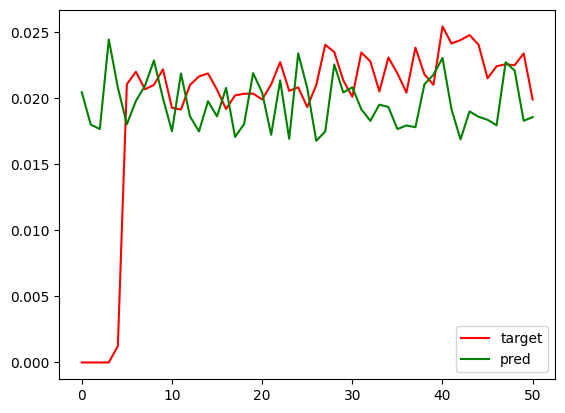

In [20]:
plt.plot((target[15]),color='red',label='target')
plt.plot((pred.numpy()[15]),color='green',label='pred')
plt.legend()
plt.savefig("First_move.png")


In [21]:
for i in range(200):
    target,pred=training_step(0.9)


tf.Tensor(123.17909, shape=(), dtype=float32)
tf.Tensor(119.86523, shape=(), dtype=float32)
tf.Tensor(115.55362, shape=(), dtype=float32)
tf.Tensor(109.83736, shape=(), dtype=float32)
tf.Tensor(102.60779, shape=(), dtype=float32)
tf.Tensor(94.16423, shape=(), dtype=float32)
tf.Tensor(85.2961, shape=(), dtype=float32)
tf.Tensor(76.43487, shape=(), dtype=float32)
tf.Tensor(70.169495, shape=(), dtype=float32)
tf.Tensor(67.10022, shape=(), dtype=float32)
tf.Tensor(65.14897, shape=(), dtype=float32)
tf.Tensor(63.960876, shape=(), dtype=float32)
tf.Tensor(64.84377, shape=(), dtype=float32)
tf.Tensor(66.52398, shape=(), dtype=float32)
tf.Tensor(67.45445, shape=(), dtype=float32)
tf.Tensor(68.36348, shape=(), dtype=float32)
tf.Tensor(69.53273, shape=(), dtype=float32)
tf.Tensor(70.228386, shape=(), dtype=float32)
tf.Tensor(69.87836, shape=(), dtype=float32)


KeyboardInterrupt: 

: 

In [ ]:
plt.plot((target[15]),color='red',label='target')
plt.plot((pred.numpy()[15]),color='green',label='pred')
plt.legend()
plt.savefig("last_move.png")


In [ ]:
action_value_dist.numpy()[0]


In [ ]:
class Agent:
    def __init__(self,environment,model,model_2,discount_factor=0.99,learning_rate=0.00025,episode=10000,batch_size=32,replay_size=1000000,staked_frame=4,fixed_epsilon=None,model_checkpoint='DQN_wights.h5',up=25,down=10,left=5,right=5,update_steps=50):
        #the environment simulator 
        self.env=environment
        # hear we made the first change where we have 2 model instead of one model the online_model and target_model 
        #  the first one it's using for compute Q_value function at each time step while the other to just compute the target.
        self.online_model=model
        # the second model is the target model have the same structure of the online model and the same inial parameter.
        self.target_model=model_2
        self.target_model.set_weights(model.get_weights())
        # the discout factor in the Q-learning algorithem
        self.discount_factor=discount_factor
        # the number of episod to run as the number of epochs in supervised learning 
        self.episodes=episode
        # onather update to the previouse alogorithem where we need parameter that difine the update rate for the target model.
        self.update_rate=update_steps
    
        self.batch_size=batch_size
        # the memory where we save the observations for training 
        self.replay_buffer=deque(maxlen=replay_size)
        # the deque used for state creation where we stacked last 4 frames togather 
        self.stacked_blocks=deque(maxlen=staked_frame)
        # if we want to stack more or less frame togather in other world if we want the state more complex or simpler.
        self.stacked_size=staked_frame
        # if we want the epsilon parameter constant during the training else the parameter will change during the training.
        self.fixed_epsilon=fixed_epsilon
        # the action space it's represent the number neuron in the output layer becouse Q function is maping from state to actions. 
        self.action_space=environment.action_space.n
        # it's rewards list where we save the reward from each episod ( from each epochs )
        self.rewards_list=[]
        # the loss function using to compute the gradiant of the model is KLD not MSE and we compute manualy.
        # self.loss_function=tf.losses.mean_squared_error
#---->   the optimizer using to update the parameter is no longer RMSprop.
        self.optimizer=tf.optimizers.Adam(learning_rate=learning_rate)
        # it's the file path, where we save the model weights
        self.model_checkpoint=model_checkpoint
        # these four parameter we use for croping the edges of the frame  
        self.up=up
        self.down=-down
        self.left=left
        self.right=-right
    
    def _preprocess_frame(self,frame):
        """
        this function make preprocessing step for each frame from the game.
        parameter: 
            -frame: is a row frame with [210*64*3] size which provided by the environment, after we make an action that change the world
            the environmnt brovide us by new observation after apply that action.
        return :
            image: processing frame where we cut some of border and keep the play area and change the image to gray scale 
            then resize it to [84,84] shape and finaly normalize pixel value to become in the range [0-1] 
        """
        # cut the porder and keep the play area
        image=frame[self.up:self.down,self.left:self.right,:]
        image=tf.image.rgb_to_grayscale(image)
        image=tf.image.resize(image,[84,84])
        # reshape becouse it's tensor [84,84,1] and we want [84,84] for make the stacking operation easy
        image=tf.reshape(image,[84,84])
        # normalizing step
        image=image/255.0
        return image
    
    def ploting_function_one(frame):
        """
        is the same as preprocessing function but we use it for viualization stuf.
        """
        image=frame[25:,:,:]
        image=cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)
        image=cv2.resize(image,(85,85))
        return image
    
    
    def _state_creator(self,frame,is_new_episod):
        """
        this function we stack last 4 frame togather to perform on state and that give us some intuition about vilocity.
        parameter :
            -frame :which is the game observation.
            -is_new_episod: boolean parameter that check if there is no previous frame and that happend in bragning of each episod.
        
        return :
            state: tensor with [84,84,4] shape which represent the state of our world.
        """
        # first preprocessing the frame.
        image=self._preprocess_frame(frame)
        # if it's new episod then stack the first frame four time 
        if is_new_episod:
            for i in range(self.stacked_size):
                self.stacked_blocks.append(image)
                
        # just push the last frame so the first frame get out from the deque
        else:
            self.stacked_blocks.append(image)
            
        # stacked the frames togather in one tensor [84,84,4]
        state=tf.stack(self.stacked_blocks,axis=2)
        
        return state
    
    def _sample_experiences(self):
        """
        This function is use to sample batch from our memory.
        
        return:
            -states:it's tensore [batch_size,image_width,image_height,stacked_size] in our case [32,84,84,4]
            -actions: it's 2D array [batch_size,action] it's the action in each state in our batch
            -rewards: it's 2D array [batch_size,reward] it's the reward in each state in out batch
            -dones : it's 2D array [batch_size, done ] where done is boolean value help us to compute the target.
            -next_state: it's tensore [batch_size,image_width,image_height,stacked_size] in our case [32,84,84,4]
        """
        # radnom indices from the replay buffer
        indices=np.random.randint(len(self.replay_buffer),size=self.batch_size)
        batch=[self.replay_buffer[index] for index in indices]
        # we combine the experiance togather where the buffer have tuple like this (state,action,reward,done,next_state)
        states,actions,rewords,dones,next_states=[np.array([experiance[field_index] for experiance in batch]) for field_index in range(5)]
        return states,actions,rewords,dones,next_states
    
    
    
    def _epsilon_greedy_policy(self,state,epsilon):
        """
        Is the epislon greedy policy whre we use epsilon value to chose an action
        where we want to palance the exploration and explotation as possiable as we can.
    
        we pick random value alpha.
            -if alpha < epsilon : chose random action
             else argmax Q(state) for all action.
        parameter :
            -state: is the current state.
            -epsilon : is the value of threshould between [0,1]
        return :
            the number of action to make 
    
        """
        if np.random.rand()<epsilon:
            return np.random.randint(self.action_space)
        else:
            # hear we use the online model for prediction of best action.
            # hears the model output is the Distribuation over each actions, so to get the best action
            # we will get the mean over each distribuation then pick the best actions 
            propapility_dist=self.online_model(state[np.newaxis])
            Q_values=tf.reduce_sum(propapility_dist*Z,axis=2)
            return tf.argmax(Q_values[0]).numpy()
    
    def _play_one_step(self,state,epsilon):      
      action=self._epsilon_greedy_policy(state,epsilon)
      next_state,reward,done,info=self.env.step(action)
      # we do that becouse we need True done value for computing the target for the model.
      if info['ale.lives']< 5:
          done=True
      stacked_next_state=self._state_creator(next_state,False)
      self.replay_buffer.append((state,action,reward,done,stacked_next_state))
      return stacked_next_state,reward,done,info
    
    def _training_step(self):
        """
        This function is the responsible for doing one training step where we sample one batch from the replay buffer 
        then we push this batch in our model for forward step and apply gradiant with optimizer by hand.
        
        return :
            None , where it's apply the change inplace for model parameter.
        """
        # get the transition (xt,at,rt,donet,xt+1) , gamma_t in [0,1] 
        states,actions,rewards,dones,next_states=self._sample_experiences()
        # we need the batch size
        batch_size=state.shape[0]
        # find the propability of the next state the output shape is [batch,action,atoms] and hear we use model in the agent we will use target model 
        # hear we calculate p(xt+1,a) but for the whole BATCH 
        next_value_dist=self.target_model(next_states) 
        # this is the Q(Xt+1,a) = Sum_i (zi*pi(xt+1,a)) the shape is [Batch,Actions] this is the Q_value for all actions 
        next_Q_values=tf.reduce_sum(next_value_dist*Z,axis=2) 
        # a* = argmax Q(xt+1,a) over a   the shape is [Batch , 1]
        best_next_actions=tf.argmax(next_Q_values,axis=1).numpy()
        # find the action-value distribuation for just the best action pj(xt+1,a*)
        next_value_dist=tf.stack([ next_value_dist[index,best_next_actions[index]] for index in np.arange(batch_size)]) # batch,ATOMS 
        # in this line we calculate the next value return [rt + gamma_t * zj ]
        T_Z=np.expand_dims(rewards,1)+ self.discount_factor * np.expand_dims((1-dones),1)*np.expand_dims(Z,0)
        # clip the value in range [VMIN,VMAX]
        clip_T_Z=np.clip(T_Z,VMIN,VMAX)
        # next return value postion  bj = (T_z - VMIN)/ Dz
        value_dist_pos=(clip_T_Z-VMIN)/DELTA_Z
        
        # l= lower [bj] , u= upper [bj] 
        lower_bound=np.floor(value_dist_pos).astype(int)
        upper_bound=np.ceil(value_dist_pos).astype(int)
        
        # this is the target distribuation  
        target_distribuation = np.zeros((batch_size,ATOMS))
        
        for i in np.arange(batch_size):
            for j in np.arange(ATOMS):
                target_distribuation[i,lower_bound[i,j]]+=(next_value_dist[i,j]*(value_dist_pos-lower_bound)[i,j])
                target_distribuation[i,upper_bound[i,j]]+=(next_value_dist[i,j]*(upper_bound-value_dist_pos)[i,j])
        
        with tf.GradientTape() as tape:
            # compute the Q function for current state (hear for the whole batch).
            all_value_dist=self.online_model(state)
            # as befor find the value distribuation for the action we made 
            action_value_dist=tf.stack([ all_value_dist[index,actions[index]] for index in np.arange(batch_size)])
            #computer the log for the propability distribuation for finding the loss 
            # log Pi(xt,at)
            log_action_value=tf.math.log(action_value_dist)
            # compute the loss using KLD 
            loss= tf.reduce_sum(-log_action_value*target_distribuation)
        # compute the gradient for our  online_model parameter.
        gradiants=tape.gradient(loss,model.trainable_variables)
        # apply the optimization step using the gradient we compute for the online_model
        optimizer.apply_gradients(zip(gradiants,model.trainable_variables))
        
    def fit(self):
        """
        This function represent the training loop function where we are trying to fit model to produce the best function
        according to the data we have.
        
        """
        for episode in tqdm.tqdm(range(self.episodes)):
            state=self.env.reset()
            stacked_state=self._state_creator(state,True)
            rewards=0
            epsilon=max(1-episode/7000,0.01)
            while True:
                stacked_state,reward,done,info=self._play_one_step(stacked_state,epsilon)
                rewards+=reward
                if done :
                    if not (episode%10) and len(self.rewards_list):
                        self.online_model.save_weights(self.model_checkpoint)
                        print("The best score for last 10 episode is: {} and the worst one is: {}".format(max(self.rewards_list[-10:]),min(self.rewards_list[-10:])))
                    self.rewards_list.append(rewards)
                    break
                # this step to let the replay buffer has some experiance
                if episode>50:
                    self._training_step()
                #hear where update the target model after 50 episod by set the parameter as online model.
                if episode%self.update_rate:
                    self.target_model.set_weights(self.online_model.get_weights())


In [ ]:
agent = Agent(env,model,model_2)
